## Support Vector Machine

In [1]:
# Imports
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Preprocessing
from transformers import AverageTransformer, DateTransformer, CyclicalTransformer, SimpleDateTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [3]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='viridis', rc={"axes.spines.right": False, "axes.spines.top": False})

In [4]:
# Data
X = pd.read_csv('data/train.csv')
y = X['TARGET_energy']
X.drop(columns=['TARGET_energy'], inplace=True)
X.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,54.264286,9.963333,92.656667,17.70,39.663333,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000,48.717990,48.717990
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,48.961111,6.466667,99.900000,15.69,38.090000,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333,42.204855,42.204855
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,45.090000,10.566667,37.993333,19.89,33.900000,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667,40.133645,40.133645
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,59.102222,8.926667,64.193333,18.79,37.637778,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333,24.570344,24.570344
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,41.290000,16.430000,1.000000,22.20,32.441429,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667,18.195913,18.195913


## Evaluation Framework

In [5]:
# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Evaluation
from functions import residual_plots, learning_curves

# Scoring Metrics
rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
r2 = make_scorer(r2_score)

## Preprocessing

In [6]:
# Drop redundant features
drop = ('drop', ['rv1', 'rv2'])

# Transformation Columns for Average Transform
T_cols = [col for col in X.columns if re.search('T\d', col)]
RH_cols = [col for col in X.columns if re.search('RH_[1-4,7-9]', col)]

# Transformations
dt = DateTransformer(['date'])
ct = CyclicalTransformer(['date'])
sdt = SimpleDateTransformer(['date'])
t_at = AverageTransformer(T_cols, ['T_avg'])
rh_at = AverageTransformer(RH_cols, ['RH_avg'])

In [7]:
# Scalers
ss = StandardScaler()
pt = PowerTransformer()
qt = QuantileTransformer()

In [8]:
# Models
svr = SVR()

## Support Vector Regression

In [9]:
svr_preprocess = make_column_transformer(drop, (dt, ['date']), remainder='passthrough')
svr_pipeline = make_pipeline(svr_preprocess, ss, svr)

params = [{
    'svr':[svr]
}]

svm_gs = GridSearchCV(svr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
svm_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('datetransformer',
                                                                         DateTransformer(date=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1, param_grid=[{'svr': [SVR()]}], refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [10]:
# Best model so far
svm_best = svm_gs.best_estimator_

In [11]:
rmse_loss = max(svm_gs.cv_results_['mean_test_rmse'])
r2_score = max(svm_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -100.452
average r squared: 0.057


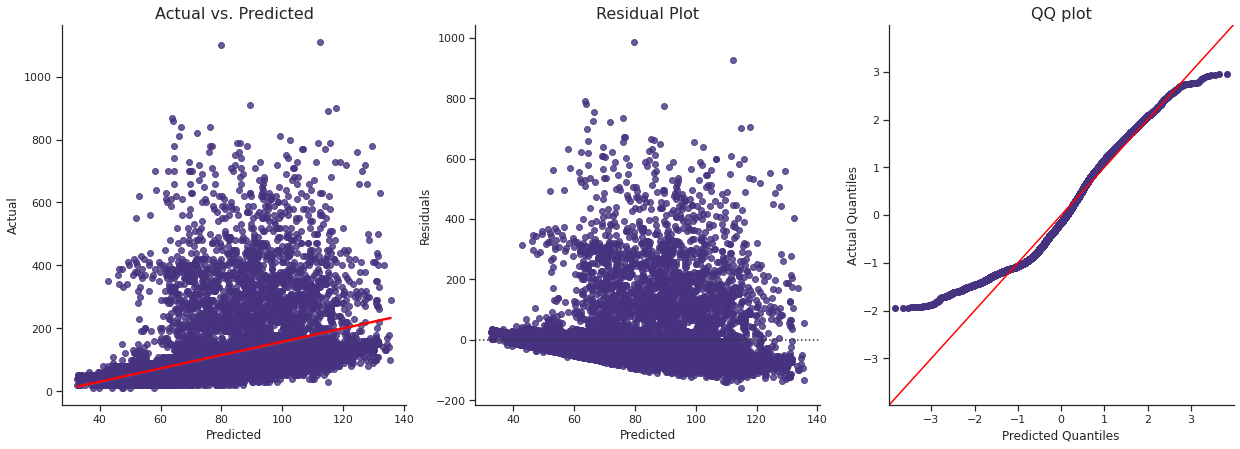

In [12]:
residual_plots(svm_best, X, y)

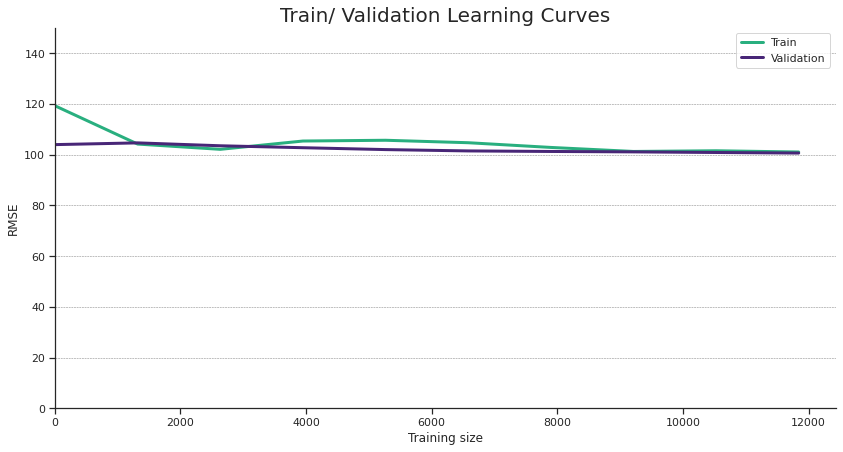

In [13]:
learning_curves(svm_best, X, y)

Although the baseline SVM model did not seem to perform very well, we might be able use the kernel trick to mimic the performance of the polynomial regression model, without the overhead CPU and RAM limitations. This can help us to reach higher polynomial degrees, as well as including more of the input features rather than reducing their complexity.

## Hyperparameter Tuning
#### Polynomial Kernel

In [14]:
params = [{
    'svr__kernel': ['poly'],
    'svr__degree': [3]
}]

svm_gs = GridSearchCV(svr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
svm_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('datetransformer',
                                                                         DateTransformer(date=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid=[{'svr__degree': [3], 'svr__kernel': ['poly']}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [15]:
rmse_loss = max(svm_gs.cv_results_['mean_test_rmse'])
r2_score = max(svm_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -101.393
average r squared: 0.039


In [16]:
params = [{
    'svr__kernel': ['poly'],
    'svr__degree': [5]
}]

svm_gs = GridSearchCV(svr_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1, cv=10)
svm_gs.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('drop',
                                                                         'drop',
                                                                         ['rv1',
                                                                          'rv2']),
                                                                        ('datetransformer',
                                                                         DateTransformer(date=['date']),
                                                                         ['date'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid=[{'svr__degree': [5], 'svr__kernel': ['poly']}],
             refit='rmse',
             scoring={'r2': make_scorer(r2_score),
                      'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False)})

In [17]:
rmse_loss = max(svm_gs.cv_results_['mean_test_rmse'])
r2_score = max(svm_gs.cv_results_['mean_test_r2'])

print(f'average root mean squared error: {rmse_loss:.3f}')
print(f'average r squared: {r2_score:.3f}')

average root mean squared error: -101.281
average r squared: 0.041


Clearly SVR is the wrong model for this dataset, and time is better spent exploring other options. Although performance in terms of resourcing is better, the RMSE loss and r squared score are significantly worse than even a regular linear regression.

In [18]:
filename = 'models/svm_best.sav'
joblib.dump(svm_best, filename)

['models/svm_best.sav']